In [6]:
import numpy as np
import imageio.v3 as iio
from scipy.ndimage import convolve, gaussian_filter, maximum_filter
import matplotlib.pyplot as plt

**Q1**: Harris Corner Detection

R(16:23, 16:23) =
 [[ 4.38955013e+03  1.66963655e+04 -7.57728123e+05 -4.23145469e+06
  -4.23485370e+06 -7.62393896e+05  1.53714965e+04]
 [ 1.65296428e+04  5.78201475e+05  1.73490743e+06 -1.14295558e+05
  -1.34965540e+05  1.70757966e+06  5.71258908e+05]
 [-7.38696249e+05  1.73254351e+06  9.56010601e+06  1.33565992e+07
   1.32823563e+07  9.47522606e+06  1.72456736e+06]
 [-4.12018250e+06 -8.33872757e+04  1.33255948e+07  2.22179125e+07
   2.21013742e+07  1.32265719e+07 -4.43222428e+04]
 [-4.11934215e+06 -1.12276113e+05  1.32019758e+07  2.20380286e+07
   2.19225334e+07  1.31041796e+07 -7.30665384e+04]
 [-7.39984429e+05  1.68683984e+06  9.38451609e+06  1.31465198e+07
   1.30746298e+07  9.30258779e+06  1.67940511e+06]
 [ 1.52096359e+04  5.61160328e+05  1.70355173e+06 -2.23156234e+04
  -4.04183624e+04  1.67965310e+06  5.55108636e+05]]


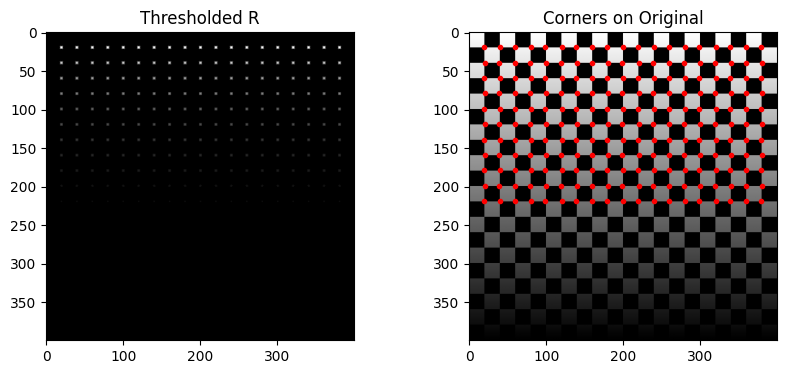

In [ ]:

sigma_I = 1.0   # gaussian window
sigma_D = 0.7   # derivative Gaussian
alpha = 0.05
threshold_R = 1e6

# load grayscale image
img = cv2.imread('checker.png', cv2.IMREAD_GRAYSCALE).astype(np.float64)

# gaussian derivative masks
def gaussian_derivative_kernels(sigma):
    size = int(np.ceil(3 * sigma)) * 2 + 1
    x = np.arange(-size//2 + 1, size//2 + 1)
    y = np.arange(-size//2 + 1, size//2 + 1)
    X, Y = np.meshgrid(x, y)
    gx = -(X / (2 * np.pi * sigma**4)) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    gy = -(Y / (2 * np.pi * sigma**4)) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    gx /= np.sum(np.abs(gx))
    gy /= np.sum(np.abs(gy))
    return gx, gy

Gx, Gy = gaussian_derivative_kernels(sigma_D)

# derivatives
Ix = convolve(img, Gx)
Iy = convolve(img, Gy)

# products and gaussian smoothing
Ixx = gaussian_filter(Ix**2, sigma=sigma_I)
Iyy = gaussian_filter(Iy**2, sigma=sigma_I)
Ixy = gaussian_filter(Ix*Iy, sigma=sigma_I)

# cornerness function
R = (Ixx * Iyy - Ixy**2) - alpha * (Ixx + Iyy)**2

# R(16:23, 16:23)
print("R(16:23, 16:23) =\n", R[16:23, 16:23])

# threshold and non-maximum suppression
R[R < threshold_R] = 0
corners = (R == maximum_filter(R, size=3)) & (R > 0)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(R, cmap='gray')
plt.title('Thresholded R')

plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
y, x = np.nonzero(corners)
plt.plot(x, y, 'r.')
plt.title('Corners on Original')
plt.show()

**Discussion:** The Harris detector found corners by analyzing local changes in image intensity. After applying Gaussian smoothing and derivative filters, the response values were thresholded and refined with non-maximum suppression. The detected corners matched well with expected checkerboard intersections.

**Q2**: FAST Feature Point Detection

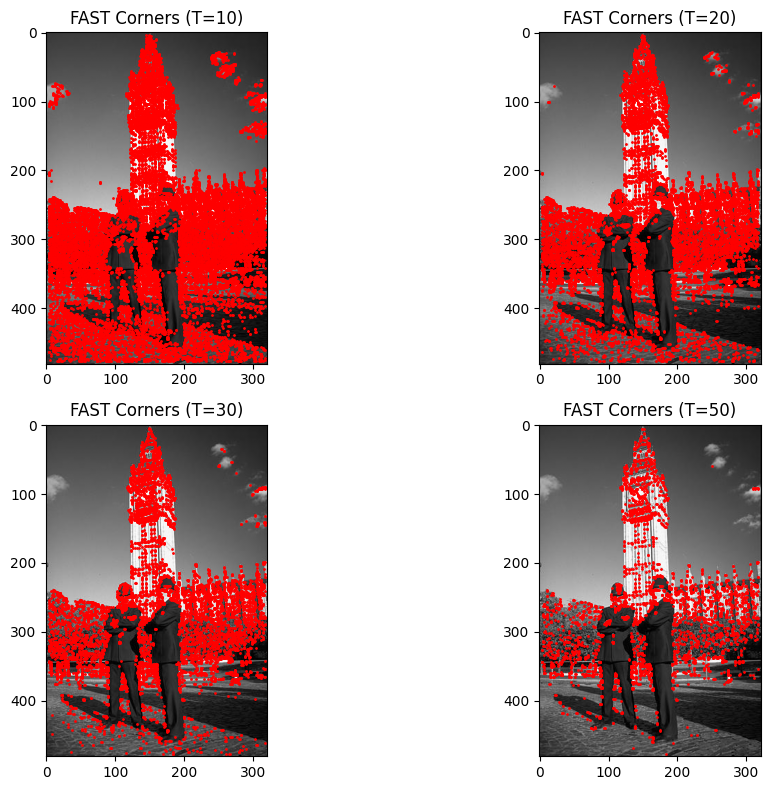

In [ ]:


# parameters
r = 3
n_star = 9
thresholds = [10, 20, 30, 50]

# load image
img = iio.imread('tower.png').astype(float)
if img.ndim == 3:
    img = np.mean(img, axis=2)


# these coordinates follow the FAST circle pattern from the slides
circle_offsets = np.array([
    [0, -3], [1, -3], [2, -2], [3, -1],
    [3, 0], [3, 1], [2, 2], [1, 3],
    [0, 3], [-1, 3], [-2, 2], [-3, 1],
    [-3, 0], [-3, -1], [-2, -2], [-1, -3]
])

# function to detect FAST corners
def fast_detector(img, T):
    h, w = img.shape
    corners = np.zeros_like(img, dtype=bool)

    for y in range(r, h - r):
        for x in range(r, w - r):
            center = img[y, x]
            circle_vals = np.array([img[y + dy, x + dx] for dx, dy in circle_offsets])
            
            above = circle_vals > center + T
            below = circle_vals < center - T

            extended = np.concatenate([above, above])  # handle wrap-around
            for i in range(16):
                if np.all(extended[i:i+n_star]):
                    corners[y, x] = True
                    break

            if not corners[y, x]:
                extended = np.concatenate([below, below])
                for i in range(16):
                    if np.all(extended[i:i+n_star]):
                        corners[y, x] = True
                        break
    return corners

# Run FAST for each threshold and display
plt.figure(figsize=(12, 8))
for i, T in enumerate(thresholds):
    corners = fast_detector(img, T)
    y, x = np.nonzero(corners)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.plot(x, y, 'r.', markersize=2)
    plt.title(f'FAST Corners (T={T})')
plt.tight_layout()
plt.show()

**Discussion:** The FAST detector checked circular pixel patterns to quickly find strong intensity changes. Using radius = 3 and different thresholds (10, 20, 30, 50), lower thresholds detected more points, while higher ones kept only the most distinct corners.